In [1]:
%matplotlib inline

import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import sys
import multiprocessing as mp
from collections import OrderedDict
import cartopy.crs as ccrs
import pickle

from tonic.io import read_configobj
import timeit

from analysis_utils import (
    rmse, find_global_param_value, determine_tile_frac, get_soil_depth,
    setup_output_dirs, calculate_rmse, calculate_pbias, to_netcdf_history_file_compress,
    calculate_crps, calculate_bias_ensemble_norm_var, calculate_nensk)

In [154]:
# ========================================================== #
# Command line arguments
# ========================================================== #
# --- Load in config file --- #
cfg = read_configobj(
    '/civil/hydro/ymao/data_assim/tools/plot_analyze_results/cfg/20180424.small_basins.synthetic.LAI_from_veglib/arkansas/sm_0.5.prec_0.3.N64/plot.EnKF_results.zero_vert_corr.cfg')

# --- Number of processors --- #
nproc = 2

In [155]:
# ========================================================== #
# Parameter setting
# ========================================================== #

# --- Synthetic analysis output data directory --- #
analysis_data_dir = cfg['SYNTHETIC']['analysis_data_dir']

# --- Zero-update analysis data directory --- #
zero_update_data_dir = cfg['EnKF']['zero_update_data_dir']

# --- Input directory and files --- #
# EnKF results
EnKF_result_basedir = cfg['EnKF']['EnKF_result_basedir']

# Post-process results
# post_result_basedir = cfg['POSTPROCESS']['post_result_basedir']

# Synthetic results basedir
gen_synth_basedir = cfg['EnKF']['gen_synth_basedir']
truth_dirname = cfg['EnKF']['truth_dirname']
truth_nc_filename = cfg['EnKF']['truth_nc_filename']

# Synthetic analysis results directory
synth_analysis_data_dir = cfg['EnKF']['synth_analysis_dir']

# openloop
openloop_basedir = cfg['EnKF']['openloop_basedir']

# VIC global file template (for extracting param file and snow_band)
vic_global_txt = cfg['EnKF']['vic_global_txt']

# Domain netCDF file
domain_nc = cfg['EnKF']['domain_nc']

# Time period
start_time = pd.to_datetime(cfg['EnKF']['start_time'])
end_time = pd.to_datetime(cfg['EnKF']['end_time'])

# VIC parameter netCDF file
vic_param_nc = cfg['EnKF']['vic_param_nc']

# --- Measurement times --- #
meas_times = pd.date_range(
    cfg['EnKF']['meas_start_time'],
    cfg['EnKF']['meas_end_time'],
    freq=cfg['EnKF']['freq'])

# --- Plot time period --- #
plot_start_time = pd.to_datetime(cfg['EnKF']['plot_start_time'])
plot_end_time = pd.to_datetime(cfg['EnKF']['plot_end_time'])
start_year = plot_start_time.year
end_year = plot_end_time.year

# --- others --- #
N = cfg['EnKF']['N']  # number of ensemble members
ens = cfg['EnKF']['ens']  # index of ensemble member to plot for debugging plots

# --- Output --- #
output_rootdir = cfg['OUTPUT']['output_dir']

In [156]:
# ========================================================== #
# Setup output data dir
# ========================================================== #
output_data_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['data'])['data']
output_maps_dir = setup_output_dirs(
                    output_rootdir,
                    mkdirs=['maps'])['maps']
output_ts_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['time_series'])['time_series']

In [157]:
# ========================================================== #
# Load data
# ========================================================== #
print('Loading data...')

# --- Domain --- #
da_domain = xr.open_dataset(domain_nc)['mask']

# --- Tile fraction --- #
da_tile_frac = determine_tile_frac(vic_global_txt)  # [veg_class, snow_band, lat, lon]

# --- Openloop --- #
print('\tOpenloop history...')
openloop_hist_nc = os.path.join(
    openloop_basedir,
    'history',
    'history.openloop.{}-{:05d}.nc'.format(
        start_time.strftime('%Y-%m-%d'),
        start_time.hour*3600+start_time.second))
ds_openloop_hist = xr.open_dataset(openloop_hist_nc)
times_correct = [pd.to_datetime(t) + pd.DateOffset(hours=3) for t in ds_openloop_hist['time'].values]
ds_openloop_hist['time'] = times_correct
# print('\tOpenloop states...')
# openloop_state_nc = os.path.join(
#     openloop_basedir,
#     'states',
#     'openloop_state_cellAvg.{}_{}.nc'.format(
#         meas_times[0].strftime('%Y%m%d'),
#         meas_times[-1].strftime('%Y%m%d')))
# ds_openloop_states = xr.open_dataset(openloop_state_nc)

# --- Truth --- #
print('\tTruth history...')
ds_truth_hist = xr.open_dataset(os.path.join(
        gen_synth_basedir, truth_dirname,
        'history', truth_nc_filename))
print('\tTruth states...')
truth_state_nc = os.path.join(
    gen_synth_basedir,
    truth_dirname,
    'states',
    'truth_state_cellAvg.{}_{}.nc'.format(
        meas_times[0].strftime('%Y%m%d'),
        meas_times[-1].strftime('%Y%m%d')))
ds_truth_states = xr.open_dataset(truth_state_nc)

# --- Measurement --- #
print('\tMeasurements...')
da_meas = xr.open_dataset(os.path.join(
    gen_synth_basedir, 'synthetic_meas',
    'synthetic_meas.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))['simulated_surface_sm']

Loading data...
	Openloop history...
	Truth history...
	Truth states...
	Measurements...


In [158]:
# --- EnKF results --- #
print('\tEnKF updated states...')
out_nc = os.path.join(
    EnKF_result_basedir,
    'states',
    'updated_concat',
    'updated_state_cellAvg.{}_{}.ens_concat.nc'.format(
         meas_times[0].strftime('%Y%m%d'),
         meas_times[-1].strftime('%Y%m%d')))
if os.path.isfile(out_nc):  # If already exists
    ds_EnKF_states_allEns = xr.open_dataset(out_nc)
else:
    list_ds_allEns = []
    for i in range(N):
        print(i+1)
        ds = xr.open_dataset(os.path.join(
            EnKF_result_basedir,
            'states',
            'updated_concat',
            'updated_state_cellAvg.{}_{}.ens{}.nc'.format(
                meas_times[0].strftime('%Y%m%d'),
                meas_times[-1].strftime('%Y%m%d'),
                i+1)))
        list_ds_allEns.append(ds)
    ds_EnKF_states_allEns = xr.concat(list_ds_allEns, dim='N')
    ds_EnKF_states_allEns.to_netcdf(out_nc)
# --- EnKF ens-mean updated states --- #
out_nc = os.path.join(
    EnKF_result_basedir,
    'states',
    'updated_concat',
    'updated_state_cellAvg.{}_{}.ens_mean.nc'.format(
         meas_times[0].strftime('%Y%m%d'),
         meas_times[-1].strftime('%Y%m%d')))
if os.path.isfile(out_nc):  # If already exists
    ds_EnKF_states = xr.open_dataset(out_nc)
else:
    ds_EnKF_states_allEns = xr.concat(list_ds_allEns, dim='N')
    ds_EnKF_states = ds_EnKF_states_allEns.mean('N')
    ds_EnKF_states.to_netcdf(out_nc)

	EnKF updated states...


In [6]:
print('EnKF history, daily ...')
# --- Load and concat daily history file of all ensemble members --- #
print('Concatenating...')
out_nc = os.path.join(
    EnKF_result_basedir, 'history', 'EnKF_ensemble_concat',
    'history.daily.allEns.{}_{}.nc'.format(start_year, end_year))
if os.path.isfile(out_nc):  # If already exists
    ds_hist_daily_allEns = xr.open_dataset(out_nc)
    da_runoff_daily_allEns = ds_hist_daily_allEns['OUT_RUNOFF']
    da_baseflow_daily_allEns = ds_hist_daily_allEns['OUT_BASEFLOW']
else:
    list_da_runoff_allEns = []
    list_da_baseflow_allEns = []
    for i in range(N):
        print(i+1)
        ds = xr.open_dataset(os.path.join(
            EnKF_result_basedir, 'history', 'EnKF_ensemble_concat',
            'history.daily.ens{}.concat.{}_{}.nc'.format(i+1, start_year, end_year)))
        list_da_runoff_allEns.append(ds['OUT_RUNOFF'])
        list_da_baseflow_allEns.append(ds['OUT_BASEFLOW'])
    da_runoff_daily_allEns = xr.concat(list_da_runoff_allEns, dim='N')
    da_baseflow_daily_allEns = xr.concat(list_da_baseflow_allEns, dim='N')
    ds_hist_daily_allEns = xr.Dataset({'OUT_RUNOFF': da_runoff_daily_allEns,
                                       'OUT_BASEFLOW': da_baseflow_daily_allEns})
    ds_hist_daily_allEns.to_netcdf(out_nc)

EnKF history, daily ...
Concatenating...
1


FileNotFoundError: [Errno 2] No such file or directory: b'/civil/hydro/ymao/data_assim/output/EnKF/small_basins/arkansas/LAI_from_veglib/sm_0.5mm.prec_0.3.N16/history/EnKF_ensemble_concat/history.daily.ens1.concat.1980_1989.nc'

In [ ]:
# --- EnKF mean --- #
out_nc = os.path.join(
    EnKF_result_basedir, 'history', 'EnKF_ensemble_concat',
    'history.daily.ens_mean.concat.{}_{}.nc'.format(start_year, end_year))
if os.path.isfile(out_nc):  # If already exists
    ds_hist_daily_ensMean = xr.open_dataset(out_nc)
else:
    ds_hist_daily_ensMean = ds_hist_daily_allEns.mean(dim='N')
    ds_hist_daily_ensMean.to_netcdf(out_nc, format='NETCDF4_CLASSIC')

In [37]:
# ======================================================== #
# Extract shared coordinates
# ======================================================== #
lat_coord = da_domain['lat']
lon_coord = da_domain['lon']

In [38]:
# ======================================================== #
# Extract soil layer depths
# ======================================================== #
da_soil_depth = get_soil_depth(vic_param_nc)  # [nlayer, lat, lon]
depth_sm1 = da_soil_depth.sel(nlayer=0)  # [lat, lon]
depth_sm2 = da_soil_depth.sel(nlayer=1)  # [lat, lon]
depth_sm3 = da_soil_depth.sel(nlayer=2)  # [lat, lon]

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


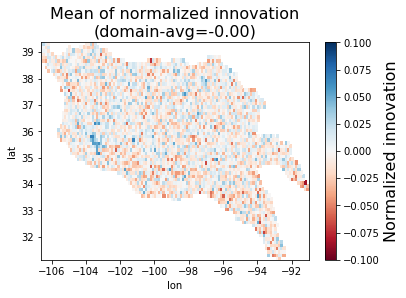

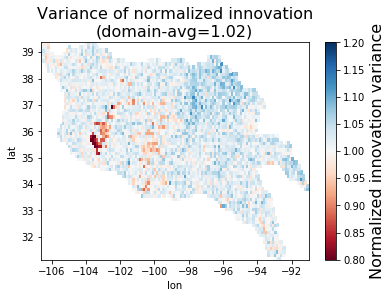

In [11]:
# ======================================================== #
# Plot innovation
# ======================================================== #
# --- Load innovation --- #
ds_innov = xr.open_dataset(os.path.join(
    EnKF_result_basedir, 'temp', 'innov', 'innov_norm.concat.{}_{}.nc'.format(start_year, end_year)))
da_innov_norm = ds_innov['innov_norm']

# --- Plot map - innovation mean --- #
fig = plt.figure()
da_innov_norm_mean = da_innov_norm.mean(dim='time').where(da_domain==1)
cs = da_innov_norm_mean.plot(add_colorbar=False, vmin=-0.1, vmax=0.1, cmap='RdBu')
cbar = plt.colorbar(cs)
cbar.set_label('Normalized innovation', fontsize=16)
plt.title(
    'Mean of normalized innovation\n(domain-avg={:.2f})'.format(
        float(da_innov_norm_mean.mean().values)),
    fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.innov_norm_mean.png'), format='png')

# --- Plot map - innovation variance --- #
fig = plt.figure()
da_innov_norm_var = da_innov_norm.var(dim='time').where(da_domain==1)
cs = da_innov_norm_var.plot(add_colorbar=False, cmap='RdBu', vmin=0.8, vmax=1.2)
cbar = plt.colorbar(cs)
cbar.set_label('Normalized innovation variance', fontsize=16)
plt.title(
    'Variance of normalized innovation\n(domain-avg={:.2f})'.format(
        float(da_innov_norm_var.mean().values)),
    fontsize=16)
# Save
fig.savefig(os.path.join(output_maps_dir, 'map.innov_norm_var.png'), format='png')

In [159]:
# ======================================================== #
# Calculate RMSE(SM_EnKF)
# ======================================================== #
print('Calculating RMSE(SM_EnKF)')
# === sm1 === #
print('\tsm1')
out_nc = os.path.join(output_data_dir, 'rmse_EnKF_sm1.nc')
da_rmse_EnKF_sm1 = calculate_rmse(
    out_nc, ds_truth_states, ds_EnKF_states,
    var='sm1', depth_sm=depth_sm1)
# === sm2 === #
print('\tsm2')
out_nc = os.path.join(output_data_dir, 'rmse_EnKF_sm2.nc')
da_rmse_EnKF_sm2 = calculate_rmse(
    out_nc, ds_truth_states, ds_EnKF_states,
    var='sm2', depth_sm=depth_sm2)
# === sm3 === #
print('\tsm3')
out_nc = os.path.join(output_data_dir, 'rmse_EnKF_sm3.nc')
da_rmse_EnKF_sm3 = calculate_rmse(
    out_nc, ds_truth_states, ds_EnKF_states,
    var='sm3', depth_sm=depth_sm3)
# === SWE === #
print('\tSWE')
out_nc = os.path.join(output_data_dir, 'rmse_EnKF_swe.nc')
da_rmse_EnKF_swe = calculate_rmse(
    out_nc, ds_truth_states, ds_EnKF_states,
    var='swe')

Calculating RMSE(SM_EnKF)
	sm1
	sm2
	sm3
	SWE


In [40]:
# ======================================================== #
# Calculate logRMSE(runoff_EnKF)
# ======================================================== #
print('Calculating logRMSE(runoff_EnKF)')
# === Surface runoff === #
print('\tsurface runoff')
out_nc = os.path.join(output_data_dir, 'rmseLog_EnKF_runoffDaily.nc')
da_logrmse_EnKF_runoffDaily = calculate_rmse(
    out_nc, ds_truth_hist, ds_hist_daily_ensMean,
    var='runoff_daily_log')
# === Baseflow === #
print('\tbaseflow')
out_nc = os.path.join(output_data_dir, 'rmseLog_EnKF_baseflowDaily.nc')
da_logrmse_EnKF_baseflowDaily = calculate_rmse(
    out_nc, ds_truth_hist, ds_hist_daily_ensMean,
    var='baseflow_daily_log')
# === Total runoff === #
print('\ttotal runoff')
out_nc = os.path.join(output_data_dir, 'rmseLog_EnKF_totrunoffDaily.nc')
da_logrmse_EnKF_totrunoffDaily = calculate_rmse(
    out_nc, ds_truth_hist, ds_hist_daily_ensMean,
    var='totrunoff_daily_log')

Calculating logRMSE(runoff_EnKF)
	surface runoff


NameError: name 'ds_hist_daily_ensMean' is not defined

In [160]:
# ======================================================== #
# Calculate PIMPROVE(SM_EnKF, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(SM_EnKF, RMSE) - daily')

# === SM1 === #
print('\tsm1')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_sm1 = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_sm1.nc'))['rmse']
pimprov_EnKF_sm1_rmse = \
    (1 - da_rmse_EnKF_sm1 / da_rmse_openloop_sm1) * 100
# === SM2 === #
print('\tsm2')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_sm2 = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_sm2.nc'))['rmse']
pimprov_EnKF_sm2_rmse = \
    (1 - da_rmse_EnKF_sm2 / da_rmse_openloop_sm2) * 100
# === SM3 === #
print('\tsm3')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_sm3 = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_sm3.nc'))['rmse']
pimprov_EnKF_sm3_rmse = \
    (1 - da_rmse_EnKF_sm3 / da_rmse_openloop_sm3) * 100
# === SWE === #
print('\tSWE')
# --- Calculate PIMPROVE --- #
da_rmse_openloop_swe = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmse_openloop_swe.nc'))['rmse']
pimprov_EnKF_swe_rmse = \
    (1 - da_rmse_EnKF_swe / da_rmse_openloop_swe) * 100

Calculating PIMPROVE(SM_EnKF, RMSE) - daily
	sm1
	sm2
	sm3
	SWE


In [42]:
# ======================================================== #
# Calculate PIMPROVE(runoff_EnKF, logRMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_EnKF, logRMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate PIMPROVE --- #
da_rmseLog_openloop_runoffDaily = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmseLog_openloop_dailyRunoff.nc'))['rmse']
pimprov_EnKF_runoff_rmseLog = \
    (1 - da_logrmse_EnKF_runoffDaily / da_rmseLog_openloop_runoffDaily) * 100
# === Baseflow === #
print('\tbaseflow')
# --- Calculate PIMPROVE --- #
da_rmseLog_openloop_baseflowfDaily = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmseLog_openloop_dailyBaseflow.nc'))['rmse']
pimprov_EnKF_baseflow_rmseLog = \
    (1 - da_logrmse_EnKF_baseflowDaily / da_rmseLog_openloop_baseflowfDaily) * 100
# === Total runoff === #
print('\ttotal runoff')
# --- Calculate PIMPROVE --- #
da_rmseLog_openloop_totrunoffDaily = xr.open_dataset(os.path.join(
    synth_analysis_data_dir,
    'rmseLog_openloop_dailyTotrunoff.nc'))['rmse']
pimprov_EnKF_totrunoff_rmseLog = \
    (1 - da_logrmse_EnKF_totrunoffDaily / da_rmseLog_openloop_totrunoffDaily) * 100

Calculating PIMPROVE(runoff_EnKF, logRMSE) - daily
	surface runoff


NameError: name 'da_logrmse_EnKF_runoffDaily' is not defined

In [16]:
def cmap_PIMPROV_listed(vmin=-100, vmax=100):
    '''listed PIMPROV colormap'''

    # Set colormap
    cmap_orig = matplotlib.cm.get_cmap('RdBu')
    
    # Set bounds
    bounds = np.array([-100, -95, -80, -50, -30, -15, -5, 
                       0, 5, 15, 30, 50, 80, 95, 100], np.float)
    n_intervals = len(bounds) - 1
    interval = 1.0 / n_intervals
    perc_array = np.arange(interval/2, 1, interval)
    red = cmap_orig(perc_array)[:, 0]
    green = cmap_orig(perc_array)[:, 1]
    blue = cmap_orig(perc_array)[:, 2]

    ticks = bounds
    colors = np.transpose(np.array([red, green, blue]))
#    bounds = (vmax - vmin) / (bounds.max()-bounds.min()) * bounds + vmin
    norm = matplotlib.colors.BoundaryNorm(bounds, colors.shape[0])
    cmap = matplotlib.colors.ListedColormap(colors)
#    cmap.set_bad('lightgray')
    return cmap, norm, ticks, colors

cmap, norm, ticks, colors = cmap_PIMPROV_listed()

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:2

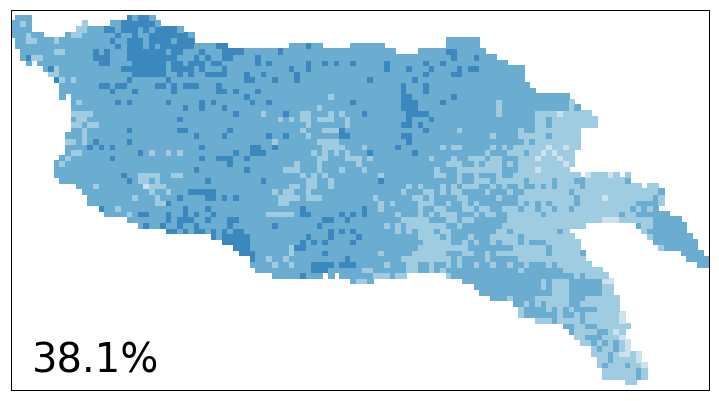

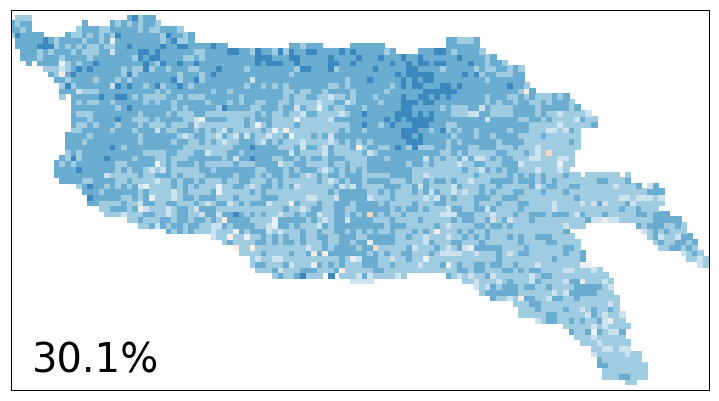

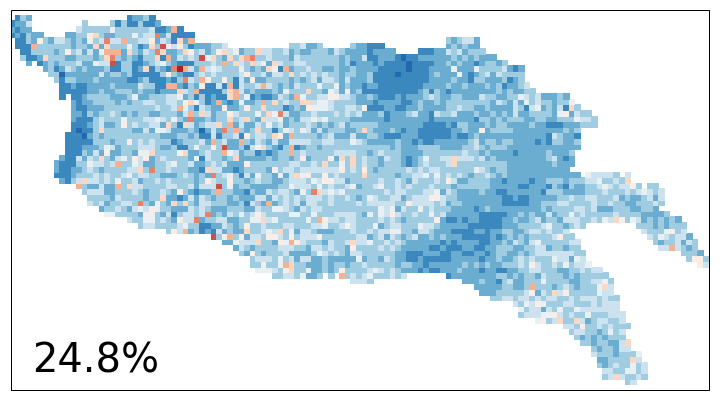

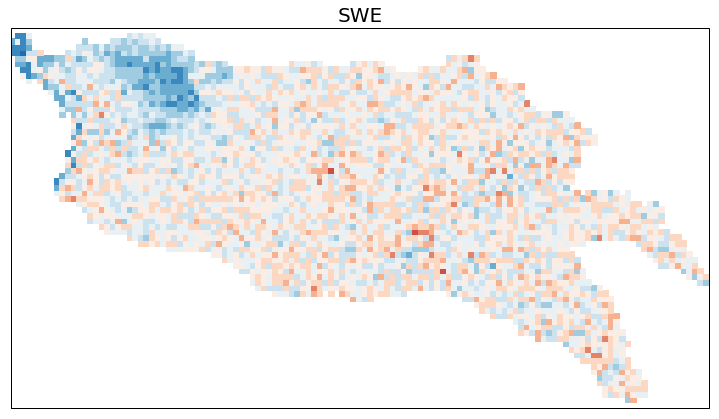

In [38]:
# --- PIMPROV(SM_EnKF, RMSE) --- #

# # --- For colorbar --- #
# fig = plt.figure(figsize=(14, 7))
# # Set projection
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
# #gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# # Plot
# cs = pimprov_EnKF_sm1_rmse.where(da_domain==1).plot.pcolormesh(
#     'lon', 'lat', ax=ax,
#     add_colorbar=False,
#     add_labels=False,
#     cmap=cmap,
#     vmin=-100, vmax=100,
#     transform=ccrs.PlateCarree())
# cbar = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.6)
# cbar.set_label('Percentage (%)', fontsize=20)
# plt.title("")
# # Make plot looks better
# for t in cbar.ax.get_xticklabels():
#     t.set_fontsize(16)
# #gl.xlabel_style = {'size': 20}
# #gl.ylabel_style = {'size': 20}
# fig.savefig(os.path.join(output_maps_dir,
#                          'pimprov_rmse.EnKF.states.for_colorbar.png'),
#             format='png', bbox_inches='tight', pad_inches=0)

# --- sm1 --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_sm1_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             pimprov_EnKF_sm1_rmse.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.sm1.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm2 --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_sm2_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             pimprov_EnKF_sm2_rmse.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.sm2.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm3 --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_sm3_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
#plt.title("{:.1f}%".format(pimprov_EnKF_sm3_rmse.where(da_domain==1).median().values), fontsize=28)
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             pimprov_EnKF_sm3_rmse.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.sm3.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- swe --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_swe_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# # Make plot looks better
# for t in cbar.ax.get_yticklabels():
#     t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
#plt.text(0.05, 0.1, "SWE", transform=ax.transAxes, horizontalalignment='left',
#         fontsize=20)
plt.title("SWE", fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.EnKF.swe.png'),
            format='png', bbox_inches='tight', pad_inches=0)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:2

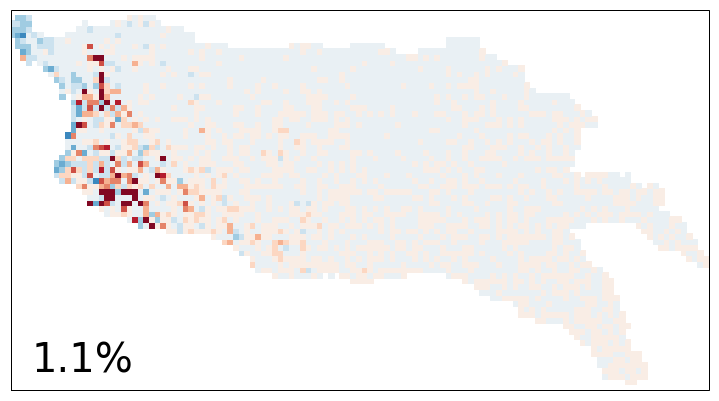

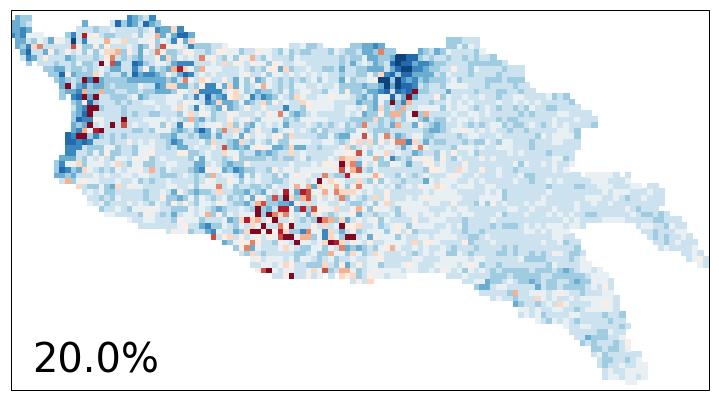

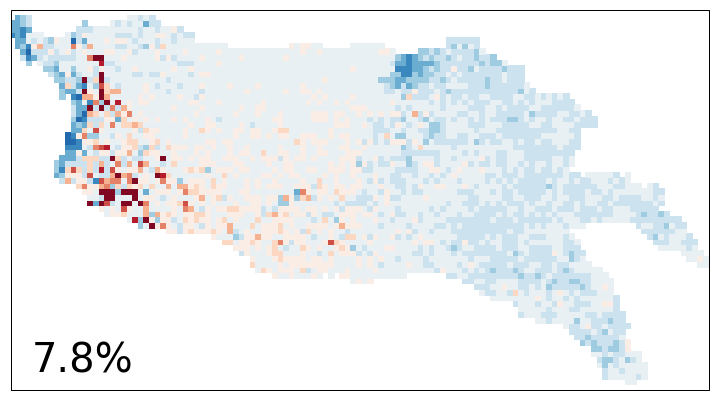

In [17]:
# --- PIMPROV(runoff_EnKF, logRMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_runoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             pimprov_EnKF_runoff_rmseLog.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.EnKF.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_EnKF, logRMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_baseflow_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             pimprov_EnKF_baseflow_rmseLog.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.EnKF.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_EnKF, logRMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_EnKF_totrunoff_rmseLog.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             pimprov_EnKF_totrunoff_rmseLog.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmseLog.EnKF.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# Ensemble statistics

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [161]:
# ======================================================== #
# Calculate CRPS(SM_EnKF)
# ======================================================== #
print('Calculating CRPS(SM_openloop)')
# === sm1 === #
print('\tsm1')
out_nc = os.path.join(output_data_dir, 'crps_EnKF_sm1.nc')
da_crps_EnKF_sm1 = calculate_crps(
    out_nc, ds_truth_states, ds_EnKF_states_allEns,
    var='sm1', depth_sm=depth_sm1)
# === sm2 === #
print('\tsm2')
out_nc = os.path.join(output_data_dir, 'crps_EnKF_sm2.nc')
da_crps_EnKF_sm2 = calculate_crps(
    out_nc, ds_truth_states, ds_EnKF_states_allEns,
    var='sm2', depth_sm=depth_sm2)
# === sm3 === #
print('\tsm3')
out_nc = os.path.join(output_data_dir, 'crps_EnKF_sm3.nc')
da_crps_EnKF_sm3 = calculate_crps(
    out_nc, ds_truth_states, ds_EnKF_states_allEns,
    var='sm3', depth_sm=depth_sm3)

Calculating CRPS(SM_openloop)
	sm1
	sm2
	sm3


In [162]:
# ======================================================== #
# Calculate PSR(SM_EnKF)
# ======================================================== #
print('Calculating PSR(SM_openloop)')
# === sm1 === #
print('\tsm1')
da_crps_zero_update_sm1 = xr.open_dataset(os.path.join(
    zero_update_data_dir, 'crps_EnKF_sm1.nc'))['crps']
da_psr_sm1 = (1 - da_crps_EnKF_sm1 / da_crps_zero_update_sm1) * 100

# === sm2 === #
print('\tsm2')
da_crps_zero_update_sm2 = xr.open_dataset(os.path.join(
    zero_update_data_dir, 'crps_EnKF_sm2.nc'))['crps']
da_psr_sm2 = (1 - da_crps_EnKF_sm2 / da_crps_zero_update_sm2) * 100

# === sm3 === #
print('\tsm3')
da_crps_zero_update_sm3 = xr.open_dataset(os.path.join(
    zero_update_data_dir, 'crps_EnKF_sm3.nc'))['crps']
da_psr_sm3 = (1 - da_crps_EnKF_sm3 / da_crps_zero_update_sm3) * 100

Calculating PSR(SM_openloop)
	sm1
	sm2
	sm3


In [46]:
# ======================================================== #
# Calculate CRPS(runoff_EnKF)
# ======================================================== #
print('Calculating CRPS(runoff_EnKF)')
# === surface runoff === #
print('\tsurface runoff')
out_nc = os.path.join(output_data_dir, 'crps_EnKF_runoff_daily_log.nc')
da_crps_EnKF_runoff = calculate_crps(
    out_nc, ds_truth_hist, ds_hist_daily_allEns,
    var='runoff_daily_log')
# === baseflow === #
print('\tbaseflow')
out_nc = os.path.join(output_data_dir, 'crps_EnKF_baseflow_daily_log.nc')
da_crps_EnKF_baseflow = calculate_crps(
    out_nc, ds_truth_hist, ds_hist_daily_allEns,
    var='baseflow_daily_log')
# === total runoff === #
print('\ttotal runoff')
out_nc = os.path.join(output_data_dir, 'crps_EnKF_totrunoff_daily_log.nc')
da_crps_EnKF_totrunoff = calculate_crps(
    out_nc, ds_truth_hist, ds_hist_daily_allEns,
    var='totrunoff_daily_log')

Calculating CRPS(runoff_EnKF)
	surface runoff


NameError: name 'ds_hist_daily_allEns' is not defined

In [47]:
# ======================================================== #
# Calculate PSR(runoff_EnKF)
# ======================================================== #
print('Calculating PSR(runoff_openloop)')
# === surface runoff === #
print('\tsurface runoff')
da_crps_zero_update_runoff = xr.open_dataset(os.path.join(
    zero_update_data_dir, 'crps_EnKF_runoff_daily_log.nc'))['crps']
da_psr_runoff = (1 - da_crps_EnKF_runoff / da_crps_zero_update_runoff) * 100
# === baseflow === #
print('\tbaseflow')
da_crps_zero_update_baseflow = xr.open_dataset(os.path.join(
    zero_update_data_dir, 'crps_EnKF_baseflow_daily_log.nc'))['crps']
da_psr_baseflow = (1 - da_crps_EnKF_baseflow / da_crps_zero_update_baseflow) * 100
# === total runoff === #
print('\ttotal runoff')
da_crps_zero_update_totrunoff = xr.open_dataset(os.path.join(
    zero_update_data_dir, 'crps_EnKF_totrunoff_daily_log.nc'))['crps']
da_psr_totrunoff = (1 - da_crps_EnKF_totrunoff / da_crps_zero_update_totrunoff) * 100

Calculating PSR(runoff_openloop)
	surface runoff


FileNotFoundError: [Errno 2] No such file or directory: b'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180424.small_basins.synthetic.LAI_from_veglib/arkansas/sm_0.5.prec_0.3.N32/EnKF.zero_update/data/crps_EnKF_runoff_daily_log.nc'

In [163]:
# ======================================================== #
# Calculate nensk(SM_EnKF)
# ======================================================== #
print('Calculating nensk(SM_openloop)')
# === sm1 === #
print('\tsm1')
out_nc = os.path.join(output_data_dir, 'nensk_EnKF_sm1.nc')
da_nensk_EnKF_sm1 = calculate_nensk(
    out_nc, ds_truth_states, ds_EnKF_states_allEns,
    var='sm1', depth_sm=depth_sm1)
# === sm2 === #
print('\tsm2')
out_nc = os.path.join(output_data_dir, 'nensk_EnKF_sm2.nc')
da_nensk_EnKF_sm2 = calculate_nensk(
    out_nc, ds_truth_states, ds_EnKF_states_allEns,
    var='sm2', depth_sm=depth_sm2)
# === sm3 === #
print('\tsm3')
out_nc = os.path.join(output_data_dir, 'nensk_EnKF_sm3.nc')
da_nensk_EnKF_sm3 = calculate_nensk(
    out_nc, ds_truth_states, ds_EnKF_states_allEns,
    var='sm3', depth_sm=depth_sm3)

Calculating nensk(SM_openloop)
	sm1
	sm2
	sm3


In [91]:
# ======================================================== #
# Calculate nensk(logRunoff_daily_EnKF)
# ======================================================== #
print('Calculating nensk(logRunoff_daily_EnKF)')
# === surface runoff === #
print('\tsurface runoff')
out_nc = os.path.join(output_data_dir, 'nensk_EnKF_logRunoffDaily.nc')
da_nensk_EnKF_logRunoffDaily = calculate_nensk(
    out_nc, ds_truth_hist, ds_hist_daily_allEns,
    var='runoff_daily_log')
# === baseflow === #
print('\tbaseflow')
out_nc = os.path.join(output_data_dir, 'nensk_EnKF_logBaseflowDaily.nc')
da_nensk_EnKF_logBaseflowDaily = calculate_nensk(
    out_nc, ds_truth_hist, ds_hist_daily_allEns,
    var='baseflow_daily_log')
# === Total runoff === #
print('\ttotal runoff')
out_nc = os.path.join(output_data_dir, 'nensk_EnKF_logTotrunoffDaily.nc')
da_nensk_EnKF_logTotrunoffDaily = calculate_nensk(
    out_nc, ds_truth_hist, ds_hist_daily_allEns,
    var='totrunoff_daily_log')

Calculating nensk(logRunoff_daily_EnKF)
	surface runoff


NameError: name 'ds_hist_daily_allEns' is not defined

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


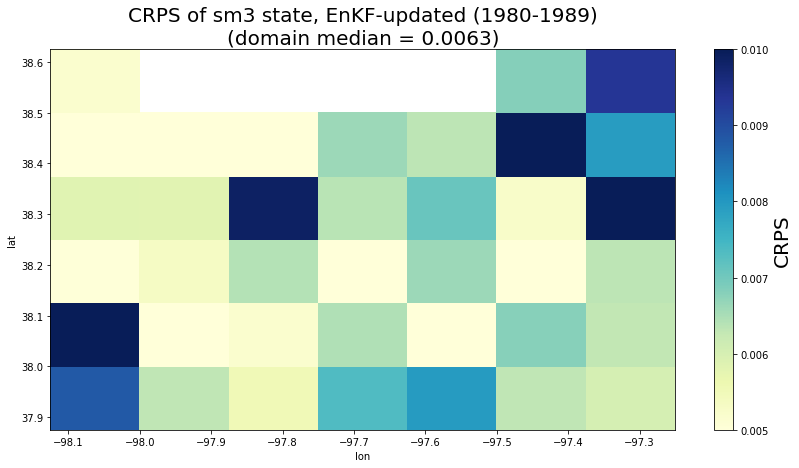

In [288]:
# ======================================================== #
# Plot maps - CRPS(SM)
# ======================================================== #
# # --- CRPS(sm1_EnKF) --- #
# fig = plt.figure(figsize=(14, 7))
# cs = da_crps_EnKF_sm1.where(da_domain==1).plot(
#     add_colorbar=False, cmap='YlGnBu', vmin=0.003, vmax=0.006)
# cbar = plt.colorbar(cs).set_label('CRPS', fontsize=20)
# plt.title('CRPS of sm1 state, EnKF-updated (1980-1989)\n'
#           '(domain median = {:.4f})'.format(da_crps_EnKF_sm1.median().values), fontsize=20)
# fig.savefig(os.path.join(output_maps_dir, 'crps.EnKF.sm1.png'), format='png',
#             bbox_inches='tight', pad_inches=0)

# # --- CRPS(sm2_EnKF) --- #
# fig = plt.figure(figsize=(14, 7))
# cs = da_crps_EnKF_sm2.where(da_domain==1).plot(
#     add_colorbar=False, cmap='YlGnBu', vmin=0.002, vmax=0.005)
# cbar = plt.colorbar(cs).set_label('CRPS', fontsize=20)
# plt.title('CRPS of sm2 state, EnKF-updated (1980-1989)\n'
#           '(domain median = {:.4f})'.format(da_crps_EnKF_sm2.median().values), fontsize=20)
# fig.savefig(os.path.join(output_maps_dir, 'crps.EnKF.sm2.png'), format='png',
#             bbox_inches='tight', pad_inches=0)

# # --- CRPS(sm3_EnKF) --- #
# fig = plt.figure(figsize=(14, 7))
# cs = da_crps_EnKF_sm3.where(da_domain==1).plot(
#     add_colorbar=False, cmap='YlGnBu', vmin=0.005, vmax=0.01)
# cbar = plt.colorbar(cs).set_label('CRPS', fontsize=20)
# plt.title('CRPS of sm3 state, EnKF-updated (1980-1989)\n'
#           '(domain median = {:.4f})'.format(da_crps_EnKF_sm3.median().values), fontsize=20)
# fig.savefig(os.path.join(output_maps_dir, 'crps.EnKF.sm3.png'), format='png',
#             bbox_inches='tight', pad_inches=0)

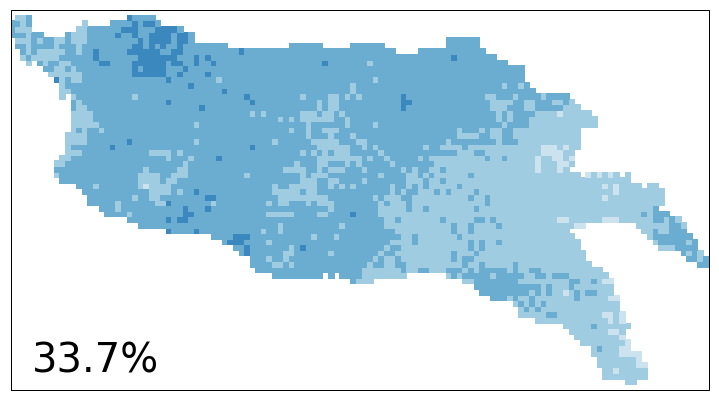

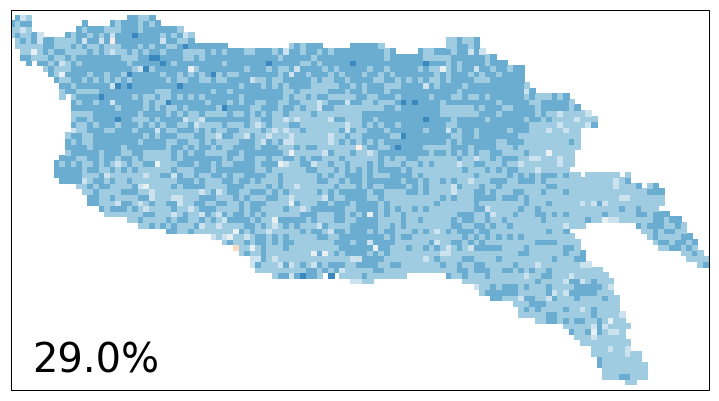

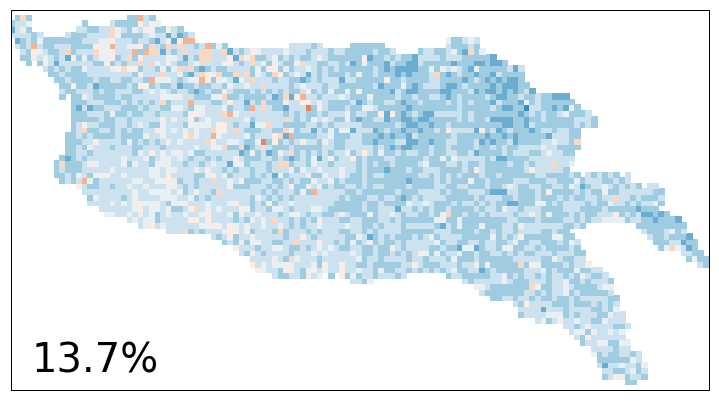

In [42]:
# ======================================================== #
# Plot maps - PSR(SM)
# ======================================================== #
# --- PSR(sm1_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_psr_sm1.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#plt.title("{:.1f}%".format(da_psr_sm1.where(da_domain==1).median().values), fontsize=28)
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             da_psr_sm1.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'psr.EnKF.sm1.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- PSR(sm2_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_psr_sm2.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             da_psr_sm2.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'psr.EnKF.sm2.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# # --- PSR(sm3_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_psr_sm3.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#plt.title("{:.1f}%".format(da_psr_sm3.where(da_domain==1).median().values), fontsize=28)
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             da_psr_sm3.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'psr.EnKF.sm3.png'), format='png',
            bbox_inches='tight', pad_inches=0)

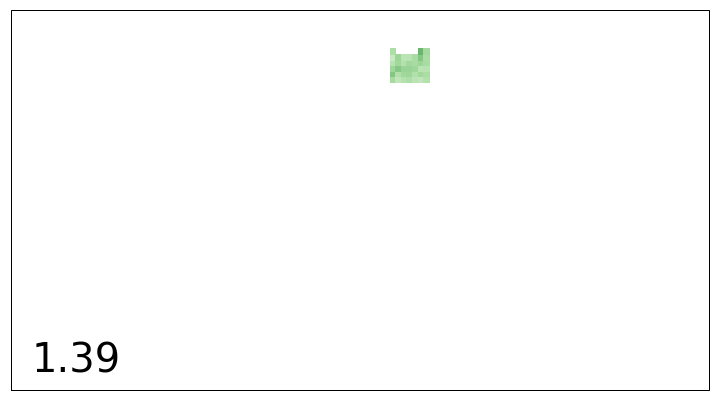

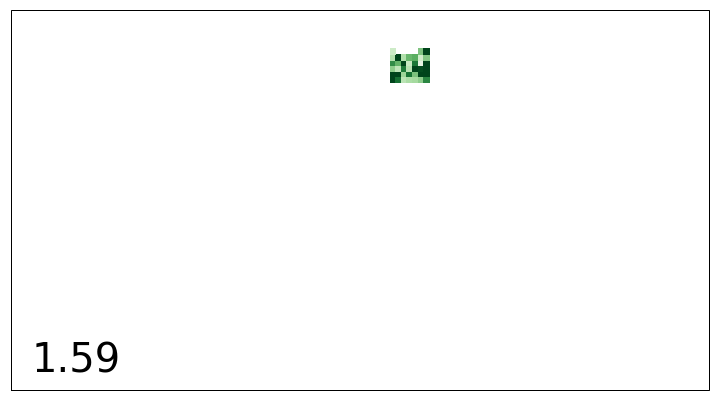

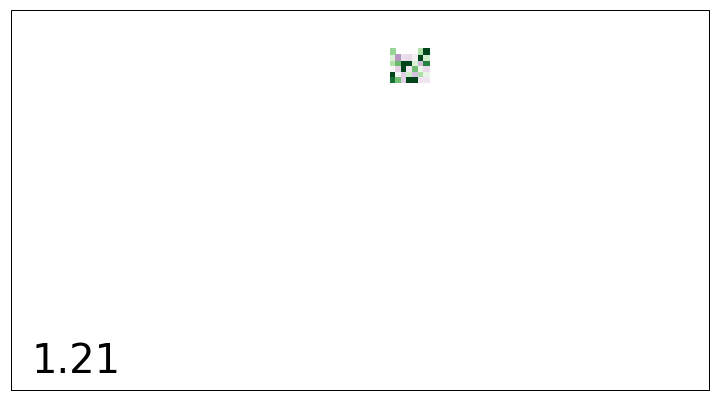

In [119]:
# ======================================================== #
# Plot maps - nensk(SM)
# ======================================================== #
# --- nensk(sm1_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_nensk_EnKF_sm1.where(da_domain==1).plot(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='PRGn',
    vmin=0, vmax=2,
    transform=ccrs.PlateCarree())
plt.text(0.03, 0.13,
         '{:.2f}'.format(
             da_nensk_EnKF_sm1.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'nensk.EnKF.sm1.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- nensk(sm2_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_nensk_EnKF_sm2.where(da_domain==1).plot(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='PRGn',
    vmin=0, vmax=2,
    transform=ccrs.PlateCarree())
plt.text(0.03, 0.13,
         '{:.2f}'.format(
             da_nensk_EnKF_sm2.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'nensk.EnKF.sm2.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- nensk(sm3_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_nensk_EnKF_sm3.where(da_domain==1).plot(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='PRGn',
    vmin=0, vmax=2,
    transform=ccrs.PlateCarree())
#plt.title('{:.2f}'.format(da_nensk_EnKF_sm3.where(da_domain==1).median().values), fontsize=28)
plt.text(0.03, 0.13,
         '{:.2f}'.format(
             da_nensk_EnKF_sm3.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'nensk.EnKF.sm3.png'), format='png',
            bbox_inches='tight', pad_inches=0)

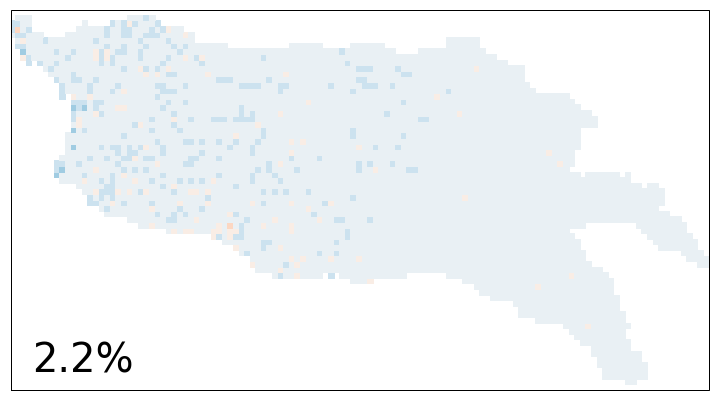

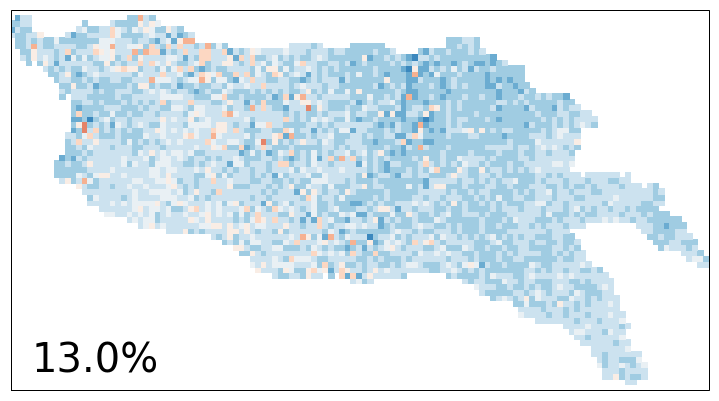

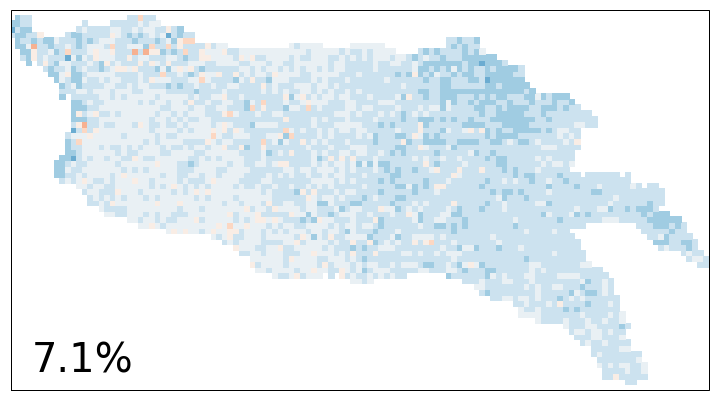

In [43]:
# ======================================================== #
# Plot maps - PSR(runoff)
# ======================================================== #
# --- PSR(runoff_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_psr_runoff.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             da_psr_runoff.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'psr.EnKF.runoff.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- PSR(baseflow_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_psr_baseflow.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             da_psr_baseflow.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'psr.EnKF.baseflow.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- PSR(totrunoff_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
cs = da_psr_totrunoff.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
plt.text(0.03, 0.13,
         '{:.1f}%'.format(
             da_psr_totrunoff.where(da_domain==1).median().values),
         horizontalalignment='left',
         verticalalignment='top',
         transform=ax.transAxes, fontsize=40)
fig.savefig(os.path.join(output_maps_dir, 'psr.EnKF.totrunoff.png'), format='png',
            bbox_inches='tight', pad_inches=0)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:2

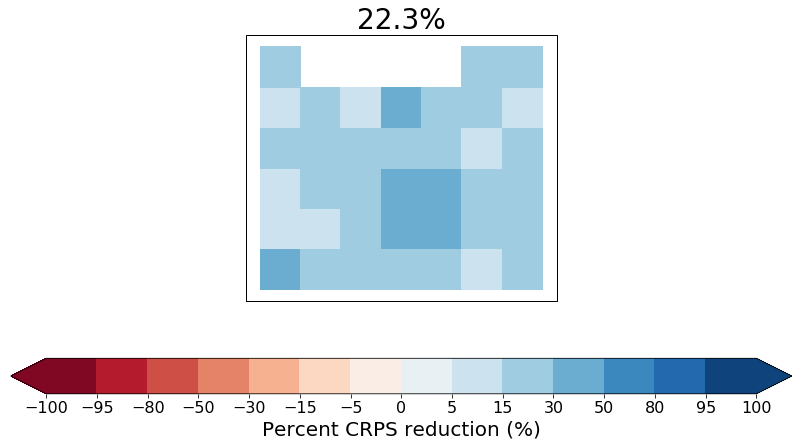

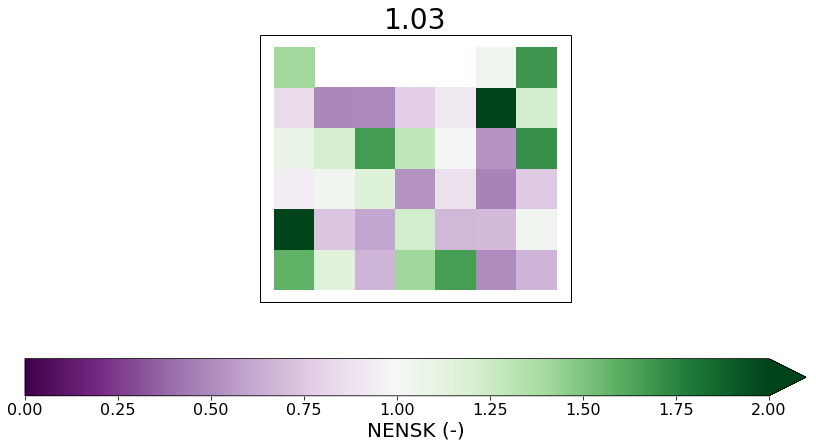

In [302]:
# ======================================================== #
# To get PSR and NENSK colorbars
# ======================================================== #
# --- PSR(sm3_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = da_psr_sm3.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap=cmap, norm=norm,
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', ticks=ticks, orientation='horizontal')
cbar.set_label('Percent CRPS reduction (%)', fontsize=20)
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
plt.title("{:.1f}%".format(da_psr_sm3.where(da_domain==1).median().values), fontsize=28)
fig.savefig(os.path.join(output_maps_dir, 'psr.colorbar.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# --- nensk(sm3_EnKF) --- #
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
cs = da_nensk_EnKF_sm3.where(da_domain==1).plot(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='PRGn',
    vmin=0, vmax=2,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='max', orientation='horizontal')
cbar.set_label('NENSK (-)', fontsize=20)
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
plt.title('{:.2f}'.format(da_nensk_EnKF_sm3.where(da_domain==1).median().values), fontsize=28)
fig.savefig(os.path.join(output_maps_dir, 'nensk.colorbar.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Time series

In [164]:
# === 36.0625, -102.0625 === #
lat = 37.9375 #34.6875
lon = -97.9375 #-94.9375
print('Plotting time series results for {} {}'.format(lat, lon))

zoomin_start_time = '1986-10-01'
zoomin_end_time = '1987-09-30'

Plotting time series results for 37.9375 -97.9375


In [165]:
# --- EnKF updated states, ensemble, zoom in --- #
print('\tEnKF updated states, ensemble...')
list_ds_EnKF_states_zoomin = []
for i in range(len(ds_EnKF_states_allEns['N'])):
    ds = ds_EnKF_states_allEns.sel(N=i)
    list_ds_EnKF_states_zoomin.append(
        ds.sel(time=slice(zoomin_start_time, zoomin_end_time)))

	EnKF updated states, ensemble...


In [14]:
# --- sm1 --- #
depth1_cell = depth_sm1.sel(lat=lat, lon=lon).values
# Extract ensemble
list_ts_to_plot_sm1 = []
for i, ds in enumerate(list_ds_EnKF_states_zoomin):
    print(i)
    list_ts_to_plot_sm1.append(ds['SOIL_MOISTURE'].sel(nlayer=0, lat=lat, lon=lon).to_series() / depth1_cell)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


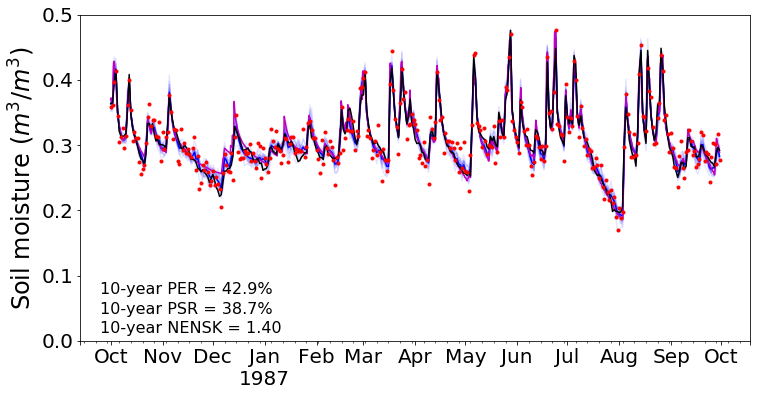

In [80]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_sm1):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_EnKF_mean = ds_EnKF_states['SOIL_MOISTURE'].sel(
    nlayer=0, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth1_cell
ts_EnKF_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_hist['OUT_SOIL_MOIST'].sel(
    nlayer=0, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth1_cell
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
    nlayer=0, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth1_cell
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# plot measurements
ts_meas = da_meas.sel(lat=lat, lon=lon).to_series().truncate(
    before=zoomin_start_time, after=zoomin_end_time) / depth1_cell
ts_meas.plot(color='r', style='.',
             label='Measurement',
             legend=False)
# Add text about PIMPROV
plt.text(0.03, 0.18,
         "10-year PER = {:.1f}%\n".format(
             float(pimprov_EnKF_sm1_rmse.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
plt.text(0.03, 0.12,
         "10-year PSR = {:.1f}%\n".format(
             float(da_psr_sm1.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
plt.text(0.03, 0.06,
         "10-year NENSK = {:.2f}\n".format(
             float(da_nensk_EnKF_sm1.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Soil moisture ($m^3/m^3$)', fontsize=24)
plt.title("")
plt.ylim([0, 0.5])
for t in ax.get_xticklabels():
    t.set_fontsize(20)
for t in ax.get_yticklabels():
    t.set_fontsize(20)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm1.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [81]:
# # Interactive
# output_file(os.path.join(output_ts_dir, '{}_{}.sm1.html'.format(lat, lon)))
# p = figure(title='SM1, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot EnKF updated states
# for ds in list_ds_EnKF_states:
#     ts = ds['SOIL_MOISTURE'].sel(nlayer=0).to_series() / \
#          depth_sm1.sel(lat=lat, lon=lon).values
#     p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
#        legend="DA ensemble updated state", line_width=2)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=0, lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=0, lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # plot measurement
# ts = da_meas.sel(lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.circle(ts.index, ts.values, color="red", fill_color="red",
#          legend="Measurement", line_width=2)
# # Save
# save(p)

In [82]:
# --- sm2 --- #
depth2_cell = depth_sm2.sel(lat=lat, lon=lon).values
# Extract ensemble
list_ts_to_plot_sm2 = []
for i, ds in enumerate(list_ds_EnKF_states_zoomin):
    list_ts_to_plot_sm2.append(ds['SOIL_MOISTURE'].sel(nlayer=1, lat=lat, lon=lon).to_series() / depth2_cell)

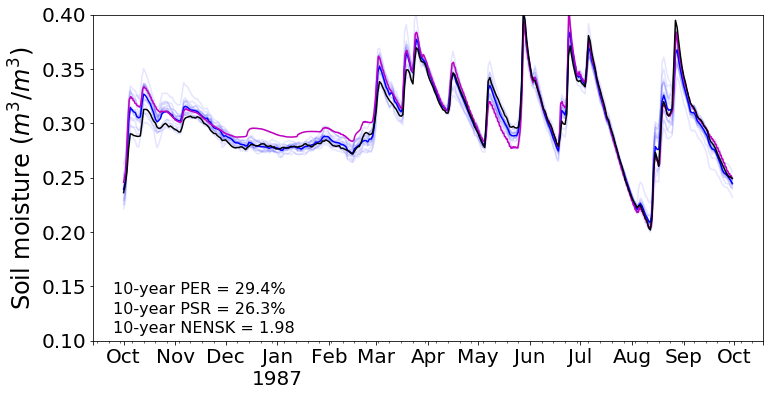

In [83]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_sm2):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_EnKF_mean = ds_EnKF_states['SOIL_MOISTURE'].sel(
    nlayer=1, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth2_cell
ts_EnKF_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_hist['OUT_SOIL_MOIST'].sel(
    nlayer=1, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth2_cell
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
    nlayer=1, lat=lat, lon=lon).to_series()\
    .truncate(before=zoomin_start_time, after=zoomin_end_time) / depth2_cell
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Add text about PIMPROV
# Add text about PIMPROV
plt.text(0.03, 0.18,
         "10-year PER = {:.1f}%\n".format(
             float(pimprov_EnKF_sm2_rmse.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
plt.text(0.03, 0.12,
         "10-year PSR = {:.1f}%\n".format(
             float(da_psr_sm2.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
plt.text(0.03, 0.06,
         "10-year NENSK = {:.2f}\n".format(
             float(da_nensk_EnKF_sm2.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Soil moisture ($m^3/m^3$)', fontsize=24)
plt.title("")
plt.ylim([0.1, 0.4])
for t in ax.get_xticklabels():
    t.set_fontsize(20)
for t in ax.get_yticklabels():
    t.set_fontsize(20)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm2.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [313]:
# # Interactive
# output_file(os.path.join(output_ts_dir, '{}_{}.sm2.html'.format(lat, lon)))
# p = figure(title='SM2, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot EnKF updated states
# for ds in list_ds_EnKF_states:
#     ts = ds['SOIL_MOISTURE'].sel(nlayer=1).to_series() / \
#          depth_sm2.sel(lat=lat, lon=lon).values
#     p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
#        legend="DA ensemble updated state", line_width=2)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

In [166]:
# --- sm3 --- #
depth3_cell = depth_sm3.sel(lat=lat, lon=lon).values
# Extract ensemble
list_ts_to_plot_sm3 = []
for i in range(len(ds_EnKF_states_allEns['N'])):
    ds = ds_EnKF_states_allEns.sel(N=i)
    list_ts_to_plot_sm3.append(ds['SOIL_MOISTURE'].sel(nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell)
# for i, ds in enumerate(list_ds_EnKF_states):
#     list_ts_to_plot_sm3.append(ds['SOIL_MOISTURE'].sel(nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell)

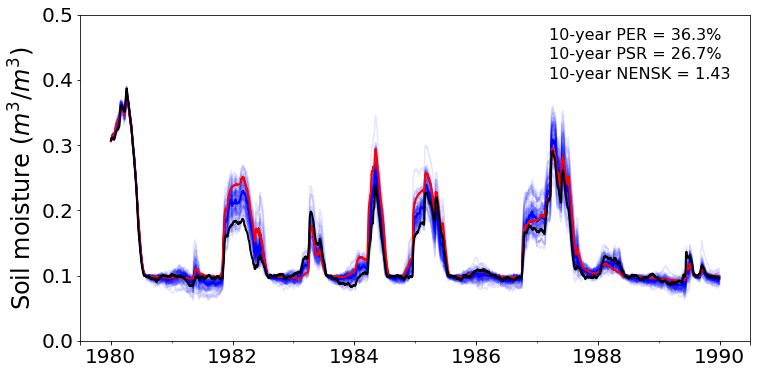

In [167]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_sm3):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_EnKF_mean = ds_EnKF_states['SOIL_MOISTURE'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
ts_EnKF_mean.plot(color='b', style='-', linewidth=2,
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_hist['OUT_SOIL_MOIST'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
ts_openloop.plot(color='r', style='-', linewidth=2,
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
ts_truth.plot(color='k', style='-', linewidth=2,
              label='Truth',
              legend=False)
# Add text about PIMPROV
# Add text about PIMPROV
plt.text(0.7, 0.96,
         "10-year PER = {:.1f}%\n".format(
             float(pimprov_EnKF_sm3_rmse.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
plt.text(0.7, 0.9,
         "10-year PSR = {:.1f}%\n".format(
             float(da_psr_sm3.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
plt.text(0.7, 0.84,
         "10-year NENSK = {:.2f}\n".format(
             float(da_nensk_EnKF_sm3.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=16)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Soil moisture ($m^3/m^3$)', fontsize=24)
plt.title("")
plt.ylim([0, 0.5])
for t in ax.get_xticklabels():
    t.set_fontsize(20)
for t in ax.get_yticklabels():
    t.set_fontsize(20)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm3.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [16]:
output_ts_dir

'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20180424.small_basins.synthetic.LAI_from_veglib/arkansas/sm_0.5.prec_0.3.N16/EnKF/time_series'

In [276]:
# # Interactive
# output_file(os.path.join(output_ts_dir, '{}_{}.sm3.html'.format(lat, lon)))
# p = figure(title='SM3, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot EnKF updated states
# for ds in list_ds_EnKF_states:
#     ts = ds['SOIL_MOISTURE'].sel(nlayer=2).to_series() / \
#          depth_sm3.sel(lat=lat, lon=lon).values
#     p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
#        legend="DA ensemble updated state", line_width=2)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

In [ ]:
fig = plt.figure(figsize=(12, 6))
mean_bias = ensemble.mean(axis=1) - truth  # [n]
plt.plot(mean_bias)
plt.ylabel('Bias (mm/mm)', fontsize=16)
plt.title('SM3 ensemble mean bias', fontsize=16)
fig.savefig(os.path.join(output_ts_dir, '{}_{}.diagnose.sm3.ensemble_mean_bias.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

fig = plt.figure(figsize=(12, 6))
std_ensemble = ensemble.std(axis=1)  # [n]
plt.plot(std_ensemble)
plt.ylabel('Standard deviation (mm/mm)', fontsize=16)
plt.title('SM3 ensemble spread (standard deviation)', fontsize=16)
fig.savefig(os.path.join(output_ts_dir, '{}_{}.diagnose.sm3.ensemble_spread.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

fig = plt.figure(figsize=(12, 6))
plt.plot(mean_bias / std_ensemble)
plt.ylabel('Ensemble skill', fontsize=16)
plt.title('SM3 ensemble skill (bias / spread)', fontsize=16)
fig.savefig(os.path.join(output_ts_dir, '{}_{}.diagnose.sm3.ensk.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Load grid-cell post-processed ensemble history --- #
file = os.path.join(output_ts_dir, "data.{}_{}.EnKF_hist.npy".format(lat, lon))
if os.path.isfile(file):
    with open(file, 'rb') as f:
        list_ds_post_history = pickle.load(f)
else:
    list_ds_post_history = []
    for i in range(N):
        history_nc = os.path.join(
            post_result_basedir,
            'history',
            'ens{}'.format(i+1),
            'history.{}_{}.{}_{}.nc'.format(lat, lon, start_year, end_year))
        list_ds_post_history.append(xr.open_dataset(history_nc).sel(lat=lat, lon=lon))
    with open(file, 'wb') as f:
        pickle.dump(list_ds_post_history, f)
# Zoomin
list_ds_post_history_zoomin = []
for i, ds in enumerate(list_ds_post_history):
    list_ds_post_history_zoomin.append(
        ds.sel(time=slice(zoomin_start_time, zoomin_end_time)))

In [ ]:
# --- surface runoff --- #
# Extract ensemble
list_ts_to_plot_runoff = []
for i, ds in enumerate(list_ds_post_history_zoomin):
    list_ts_to_plot_runoff.append(ds['OUT_RUNOFF'].to_series().resample('1D', how='sum'))

In [ ]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_runoff):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = ds_post_mean_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Add text about PIMPROV
plt.text(0.03, 0.95,
         "10-year PIMPROV(fast-response runoff$_{{DA}}$, RMSE$_{{log}}$) = {:.0f}%".format(
             float(pimprov_postMean_dailyRunoff_rmseLog.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=22)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Runoff (mm/day)', fontsize=24)
plt.title("")
plt.ylim([0, 10])  ########## change for each grid cell ###########
for t in ax.get_xticklabels():
    t.set_fontsize(20)
for t in ax.get_yticklabels():
    t.set_fontsize(20)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.runoff.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# # Interactive
# output_file(os.path.join(output_ts_dir, '{}_{}.runoff.html'.format(lat, lon)))
# p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Surface runoff (mm/day)",
#            x_axis_type='datetime', width=1000, height=500)
# # post-processed ensemble
# for ds in list_ds_post_history:
#     ts = ds['OUT_RUNOFF'].sel(lat=lat, lon=lon).to_series().resample('1D', how='sum')
#     p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
#        legend="DA post-processed ensemble", line_width=2)
# # plot open-loop
# ts = ds_openloop_hist['OUT_RUNOFF'].sel(
#     lat=lat, lon=lon).to_series().resample('1D', how='sum')
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_hist['OUT_RUNOFF'].sel(
#     lat=lat, lon=lon).to_series().resample('1D', how='sum')
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

In [ ]:
# --- Baseflow --- #
# Extract ensemble
list_ts_to_plot_baseflow = []
for i, ds in enumerate(list_ds_post_history_zoomin):
    list_ts_to_plot_baseflow.append(ds['OUT_BASEFLOW'].to_series().resample(
        '1D', how='sum'))

In [ ]:
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i, ts in enumerate(list_ts_to_plot_baseflow):
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = ds_post_mean_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = ds_openloop_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = ds_truth_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Add text about PIMPROV
plt.text(0.03, 0.95,
         "10-year PIMPROV(slow-response runoff$_{{DA}}$, RMSE$_{{log}}$) = {:.0f}%".format(
             float(pimprov_postMean_dailyBaseflow_rmseLog.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=22)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Runoff (mm/day)', fontsize=24)
plt.title("")
plt.ylim([0, 10])  ########## change for each grid cell ###########
for t in ax.get_xticklabels():
    t.set_fontsize(20)
for t in ax.get_yticklabels():
    t.set_fontsize(20)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.baseflow.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# # Interactive
# output_file(os.path.join(output_ts_dir, '{}_{}.baseflow.html'.format(lat, lon)))
# p = figure(title='Baseflow, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
#            x_axis_type='datetime', width=1000, height=500)
# # post-processed ensemble
# for ds in list_ds_post_history:
#     ts = ds['OUT_BASEFLOW'].sel(lat=lat, lon=lon).to_series().resample('1D', how='sum')
#     p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
#        legend="DA post-processed ensemble", line_width=2)
# # plot open-loop
# ts = ds_openloop_hist['OUT_BASEFLOW'].sel(
#     lat=lat, lon=lon).to_series().resample('1D', how='sum')
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_hist['OUT_BASEFLOW'].sel(
#     lat=lat, lon=lon).to_series().resample('1D', how='sum')
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # Save
# save(p)

In [ ]:
# --- Total runoff --- #
# zoomin
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# plot EnKF updated states
for i in range(N):
    ts = list_ts_to_plot_runoff[i] + list_ts_to_plot_baseflow[i]
    if i == 0:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
    else:
        ts.plot(color='blue', style='-', alpha=0.1,
            label='DA ensemble updated state',
            legend=False)
# plot ensemble-mean updated states
ts_post_mean = (ds_post_mean_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon) + \
                ds_post_mean_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon)).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_post_mean.plot(color='b', style='-',
                 label='Open-loop',
                 legend=False)
# plot open-loop
ts_openloop = (ds_openloop_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon) + \
               ds_openloop_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon)).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=False)
# plot truth
ts_truth = (ds_truth_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon) + \
            ds_truth_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon)).to_series().truncate(
        before=zoomin_start_time, after=zoomin_end_time).resample('1D', how='sum')
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=False)
# Add text about PIMPROV
plt.text(0.03, 0.95,
         "10-year PIMPROV(total runoff$_{{DA}}$, RMSE$_{{log}}$) = {:.0f}%".format(
             float(pimprov_postMean_dailyTotrunoff_rmseLog.loc[lat, lon].values)),
         horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes, fontsize=22)
# Make plot looks better
plt.xlabel("", fontsize=16)
plt.ylabel('Runoff (mm/day)', fontsize=24)
plt.title("")
plt.ylim([0, 10])  ########## change for each grid cell ###########
for t in ax.get_xticklabels():
    t.set_fontsize(20)
for t in ax.get_yticklabels():
    t.set_fontsize(20)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.totrunoff.zoomin.png'.format(lat, lon)),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# --- SM3, subdaily --- #
depth3_cell = depth_sm3.sel(lat=lat, lon=lon).values
output_file(os.path.join(output_ts_dir, '{}_{}.sm3_subdaily.html'.format(lat, lon)))
p = figure(title='SM3, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moisture (mm/mm)",
           x_axis_type='datetime', width=1000, height=500)
# post-processed ensemble
for ds in list_ds_post_history:
    ts = ds['OUT_SOIL_MOIST'].sel(
        lev=3, lat=lat, lon=lon).to_series() / depth3_cell
    p.line(ts.index, ts.values, color="blue", line_dash="solid", alpha=0.2,
       legend="DA post-processed ensemble", line_width=2)
# plot open-loop
ts = ds_openloop_hist['OUT_SOIL_MOIST'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ds_truth_hist['OUT_SOIL_MOIST'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth3_cell
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

# Other - baseflow curve

In [ ]:
lat = 31.1875
lon = -92.6875

In [ ]:
# ARNO baseflow option
ds_param = xr.open_dataset(vic_param_nc)
ds_param_cell = ds_param.sel(lat=lat, lon=lon)

In [ ]:
Ds = ds_param_cell['Ds'].values
Dsmax = ds_param_cell['Dsmax'].values
Ws = ds_param_cell['Ws'].values
c = ds_param_cell['c'].values
print('Ds: {}'.format(Ds))
print('Dsmax: {}'.format(Dsmax))  # [mm/day]
print('Ws: {}'.format(Ws))
print('c: {}'.format(c))

In [ ]:
# Calculate Wmax (maximum bottom-layer soil moisture)
porosity = 1 - ds_param_cell['bulk_density'].values / \
                ds_param_cell['soil_density'].values
Wmax_all_layers = ds_param_cell['depth'].values * porosity * 1000  # [mm]
Wmax = Wmax_all_layers[-1]

In [ ]:
# --- Plot baseflow drainage curve --- #
fig = plt.plot(figsize=(12, 6))
# Linear drainage part
plt.plot([0, Ws*Wmax], [0, Ds * Dsmax], 'b-')
# Non-linear drainage part
x = np.arange(Ws*Wmax, Wmax, 0.5)
y = Dsmax * Ds / Ws * x / Wmax + \
    Dsmax * (1 - Ds / Ws) * np.power((x / Wmax - Ws) / (1 - Ws), c)
plt.plot(x, y, 'b-')
plt.xlabel('Bottom-layer soil moisture (mm)', fontsize=16)
plt.ylabel('Baseflow (mm/day)', fontsize=16)
plt.title('Baseflow drainage curve, {} {}\nMaurer parameters'.format(lat, lon),
          fontsize=16)
plt.savefig(os.path.join(output_ts_dir,
                         'baseflow_curve.{}_{}.png'.format(lat, lon)),
            format='png')

In [ ]:
depth3_cell = depth_sm3.sel(lat=lat, lon=lon).values

In [ ]:
# --- Plot baseflow curve in terms of volumetric SM3 --- #
fig = plt.plot(figsize=(12, 6))
# Linear drainage part
plt.plot([0, Ws*Wmax] / depth3_cell, [0, Ds * Dsmax], 'b-')
# Non-linear drainage part
x = np.arange(Ws*Wmax, Wmax, 0.5)
y = Dsmax * Ds / Ws * x / Wmax + \
    Dsmax * (1 - Ds / Ws) * np.power((x / Wmax - Ws) / (1 - Ws), c)
plt.plot(x / depth3_cell, y, 'b-')
plt.xlabel('Bottom-layer soil moisture,\nnormalized by depth (mm/mm)', fontsize=16)
plt.ylabel('Baseflow (mm/day)', fontsize=16)
plt.title('Baseflow drainage curve, {} {}\nMaurer parameters'.format(lat, lon),
          fontsize=16)
plt.savefig(os.path.join(output_ts_dir,
                         'baseflow_curve.{}_{}.volumetric.png'.format(lat, lon)),
            format='png')